In [36]:
import os
import gzip
import itertools
import sys
import json
import glob
from tqdm.auto import tqdm
import numpy as np
import pycocotools.mask as mask_util
import io
import contextlib
from multiprocessing import Pool
import pickle
from scipy.stats import gmean
from scipy.special import softmax
from collections import defaultdict
from scipy.signal import find_peaks, medfilt

In [2]:
PATH_TO_ANNS = "../data/val_annot.json"
PATH_TO_PREDS = "/scratch/shared/beegfs/prannay/ego4d_data/ckpt/results/traces_v2_all/vq_stats_val_{}.json.gz"
PATH_TO_DINO = "/scratch/shared/beegfs/prannay/ego4d_data/ckpt/results/traces_v2_all/vq_stats_val_{}_dino_scores_all.pkl"
assert os.path.exists(PATH_TO_ANNS)

In [3]:
with open(PATH_TO_ANNS, "r") as f:
    anns = json.load(f)


In [4]:
PRED_IDXS = range(0, 200)
path_to_preds = [PATH_TO_PREDS.format(i) for i in PRED_IDXS]
assert all([os.path.exists(p) for p in path_to_preds])
path_to_dinos = [PATH_TO_DINO.format(i) for i in PRED_IDXS]
assert all([os.path.exists(p) for p in path_to_dinos])

In [5]:
def preprocess_data(path):
    with gzip.open(path, "r") as f:
        data = json.load(f)
    data = data['predictions']
    # convert generic Dict[List] to List[Dict]
    out_list = []
    keys = sorted(data.keys())
    for idx in range(len(data[keys[0]])):
        save_dict = {k: data[k][idx] for k in keys}
        save_dict['dataset_uid'] = save_dict['dataset_uids']
        del save_dict['dataset_uids'] 
        out_list.append(save_dict)
    return out_list

In [6]:
def preprocess_dino(path):
    with open(path, "rb") as f:
        dino_data = pickle.load(f)
    return dict(dino_data)
    

In [7]:
with Pool(48) as p:
    predictions_raw = list(tqdm(p.imap_unordered(preprocess_data, path_to_preds), total=len(path_to_preds)))
# predictions_raw = []
# for path_to_pred in tqdm(path_to_preds, total=len(path_to_preds)):
#     # with gzip.open(path_to_pred, "rt") as f:
#     predictions_raw.append(preprocess_data(path_to_pred))

  0%|          | 0/200 [00:00<?, ?it/s]

In [8]:
predictions_raw = list(itertools.chain(*predictions_raw))

In [9]:
duid2dino = {}
for path_to_dino in tqdm(path_to_dinos, total=len(path_to_dinos)):
    duid2dino.update(preprocess_dino(path_to_dino))

  0%|          | 0/200 [00:00<?, ?it/s]

In [10]:
print(type(predictions_raw[0]))
print(len(predictions_raw[0]))
print(predictions_raw[0].keys())
print(predictions_raw[0]['dataset_uid'])

<class 'dict'>
8
dict_keys(['groundtruth_response_tracks', 'predicted_bboxes', 'predicted_peaks', 'predicted_scores', 'predicted_trace_fnos', 'predicted_trace_scores', 'visual_crop', 'dataset_uid'])
val_0000000743


In [11]:
valid_duids = set([ann['dataset_uid'] for ann in anns if ann['clip_uid'] is not None])

In [12]:
duid2pred = {p['dataset_uid']: p for p in predictions_raw if p['dataset_uid'] in valid_duids}
print(len(duid2pred))
duid2gt = {ann['dataset_uid']: ann for ann in anns if ann['dataset_uid'] in duid2pred}
print(len(duid2gt))
duid2dino = {duid: duid2dino[duid] for duid in duid2pred}
print(sorted(duid2gt.keys())[:5])
print(len(duid2dino))


4504
4504
['val_0000000000', 'val_0000000001', 'val_0000000002', 'val_0000000003', 'val_0000000004']
4504


In [39]:
valid_duids = sorted(list(valid_duids))

In [40]:
print(duid2pred['val_0000000000'].keys())
# print(duid2dino['val_0000000000'][1])
# print(softmax(duid2dino["val_0000000000"][1] * 50.0))

dict_keys(['groundtruth_response_tracks', 'predicted_bboxes', 'predicted_peaks', 'predicted_scores', 'predicted_trace_fnos', 'predicted_trace_scores', 'visual_crop', 'dataset_uid'])


In [41]:
for duid in valid_duids:
    assert len(duid2pred[duid]['predicted_trace_scores']) == len(duid2dino[duid]), (len(duid2pred[duid]['predicted_trace_scores']), len(duid2dino[duid][1]))

In [42]:
def get_modulated_traces(duid2pred, duid2dino, duids):
    modulated_traces = defaultdict(dict)
    for duid in tqdm(duids, total=len(duids)):
        pred = duid2pred[duid]['predicted_trace_scores']
        dino = [x[0] for x in duid2dino[duid]]
        pred_np = np.array(pred)
        dino_np = np.array(dino)
        # keep dino_np above eps
        dino_np = np.maximum(dino_np, 1e-6)
        mod_np = np.sqrt(pred_np * dino_np)
        modulated_traces[duid]['modulated_scores'] = mod_np
        modulated_traces[duid]['original_scores'] = pred_np
        modulated_traces[duid]['frame_nos'] = duid2pred[duid]['predicted_trace_fnos']
    return dict(modulated_traces)

In [43]:
duid2mod_scores = get_modulated_traces(duid2pred, duid2dino, valid_duids)

  0%|          | 0/4504 [00:00<?, ?it/s]

In [70]:
def extract_peaks(duid2mod_scores, duids, mod_h_range=(0.1, 0.9), mod_d_range=(3, 25)):
    peaks = defaultdict(dict)
    for duid in tqdm(duids, total=len(duids)):
        mod_scores = duid2mod_scores[duid]['modulated_scores']
        orig_scores = duid2mod_scores[duid]['original_scores']
        frame_nos = duid2mod_scores[duid]['frame_nos']
        # smoothing sigma 5
        # distance 25
        # height 0.6
        # width 3
        # prominence 0.2
        orig_scores_sm = medfilt(orig_scores, 5)
        mod_scores_sm = medfilt(mod_scores, 5)
        orig_peaks = find_peaks(
            orig_scores_sm,
            distance=25,
            height=0.6,
            width=3,
            prominence=0.2
        )[0]
        peaks[duid]['orig_peaks'] = orig_peaks
        mod_peaks = find_peaks(
            mod_scores_sm,
            distance=25,
            height=0.6,
            width=3,
            prominence=0.2,
        )[0]
        peaks[duid]['mod_peaks'] = mod_peaks
        for h in np.arange(mod_h_range[0], mod_h_range[1]+1.e-6, 0.1):
            for d in np.arange(mod_d_range[0], mod_d_range[1]+1, 5):
                d = int(d)
                orig_peaks_new = find_peaks(
                    orig_scores_sm,
                    distance=d,
                    height=h,
                    width=3,
                    prominence=0.2,
                )[0]
                peaks[duid][f'orig_peaks_h_{h:.1f}_d_{d:02d}'] = orig_peaks_new
                mod_peaks_new = find_peaks(
                    mod_scores_sm,
                    distance=d,
                    height=h,
                    width=3,
                    prominence=0.2
                )[0]
                peaks[duid][f'mod_peaks_h_{h:.1f}_d_{d:02d}'] = mod_peaks_new
        
    return dict(peaks)

In [71]:
duid2peaks = extract_peaks(duid2mod_scores, valid_duids)

  0%|          | 0/4504 [00:00<?, ?it/s]

In [72]:
def get_peaks_class(duid2pred, various_peaks, valid_duids):
    peaks_class = defaultdict(dict)
    for duid in tqdm(valid_duids):
        gt_fnos = set([
            x['frame_number']
            for x in duid2pred[duid]['groundtruth_response_tracks']
        ])
        min_fno, max_fno = min(gt_fnos), max(gt_fnos)
        peaks_dict = various_peaks[duid]
        for k, v in peaks_dict.items():
            stats = []
            for p in v:
                if min_fno <= p <= max_fno:
                    stats.append(0)
                elif p < min_fno:
                    stats.append(-1)
                elif p > max_fno:
                    stats.append(1)
            peaks_class[duid][k] = stats
    return dict(peaks_class)

In [73]:
duid2peakclasses = get_peaks_class(duid2pred, duid2peaks, valid_duids)

  0%|          | 0/4504 [00:00<?, ?it/s]

In [79]:
# print average of peaks_class final class
# if the peak class list is empty for a given key count as false
def get_peak_class_stats(duid2peakclasses, valid_duids):
    peak_class_stats = defaultdict(list)
    for duid in tqdm(valid_duids):
        peak_class_dict = duid2peakclasses[duid]
        for k, v in peak_class_dict.items():
            if len(v) == 0:
                peak_class_stats[k].append(-2)
            else:
                peak_class_stats[k].append(v[-1])
    # for k, v in peak_class_stats.items():
    #     print(k, np.mean(np.array(v) == 0).astype(np.float32))
    return dict(peak_class_stats)

In [80]:
peak_class_stats = get_peak_class_stats(duid2peakclasses, valid_duids)

  0%|          | 0/4504 [00:00<?, ?it/s]

In [88]:
overall_success = defaultdict(dict)
for k, v in peak_class_stats.items():
    # if k == 'orig_peaks':
    #     print(v)
    for cls in [-2, -1, 0, 1]:
        overall_success[k][cls] = np.mean(np.array(v) == cls).astype(np.float32)
overall_success = dict(overall_success)
# print(overall_success)
best_key = max(overall_success, key=lambda x: overall_success[x][0])
print(best_key, overall_success[best_key])
print(best_key.replace('mod_peaks', 'orig_peaks'), overall_success[best_key.replace('mod_peaks', 'orig_peaks')])
print('orig_peaks', overall_success['orig_peaks'])
print('mod_peaks', overall_success['mod_peaks'])
print('mod_peaks_h_0.9_d_03', overall_success['mod_peaks_h_0.9_d_03'])

mod_peaks_h_0.4_d_03 {-2: 0.06904973, -1: 0.1911634, 0: 0.5788188, 1: 0.16096804}
orig_peaks_h_0.4_d_03 {-2: 0.06394316, -1: 0.19804618, 0: 0.54085255, 1: 0.19715808}
orig_peaks {-2: 0.1178952, -1: 0.2910746, 0: 0.4766874, 1: 0.11434281}
mod_peaks {-2: 0.16452043, -1: 0.30817053, 0: 0.46825045, 1: 0.059058614}
mod_peaks_h_0.9_d_03 {-2: 0.69515985, -1: 0.2160302, 0: 0.079262875, 1: 0.00954707}


In [124]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.ticker as ticker

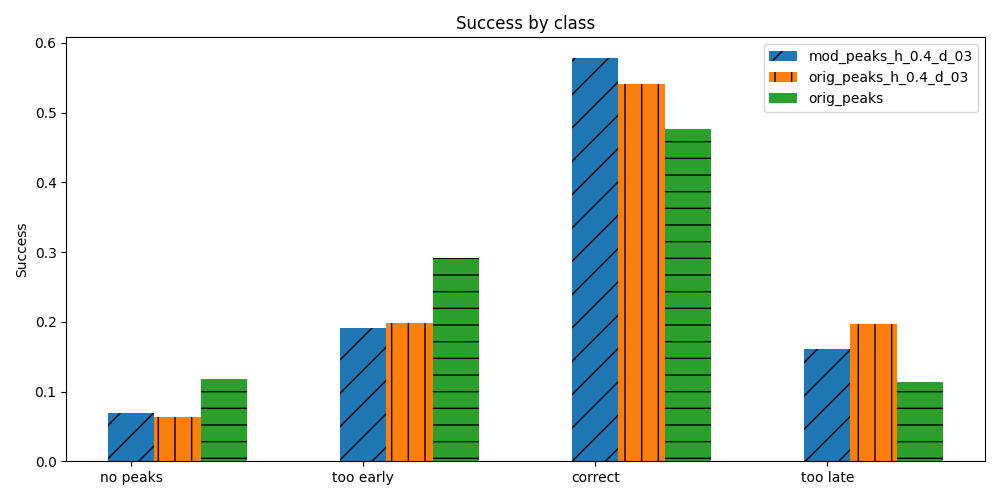

In [129]:
# plot per class success for mod_peaks_h_0.4_d_03, orig_peaks as bar chart
clsid2name = {
    -1: 'too early',
    0: 'correct',
    1: 'too late',
    -2: 'no peaks'
}

def plot_class_successes(overall_success, keys=[]):
    # use shading for bars
    assert len(keys) > 0
    fig, ax = plt.subplots(figsize=(10, 5))
    classes = [-2, -1, 0, 1]
    x = np.arange(len(classes))
    patterns = [ "/", "|" , "-" , "+" , "\\", "x", "o", "O", ".", "*" ]
    width = 0.2
    for i, key in enumerate(keys):
        ax.bar(x + i*width, [overall_success[key][cls] for cls in classes], width, label=key, hatch=patterns[i])
    ax.set_ylabel('Success')
    ax.set_title('Success by class')
    ax.set_xticks(x)
    ax.set_xticklabels([clsid2name[cls] for cls in classes])
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_class_successes(overall_success, ['mod_peaks_h_0.4_d_03', 'orig_peaks_h_0.4_d_03', 'orig_peaks'])


In [122]:
# for mod_peaks plot heatmap of class success rate
# use h value as y axis and d value as x axis
# for each h, d pair plot the overall success rate

def get_peak_class_stats_per_h_d(overall_success, prefix='mod_peaks_'):
    peak_class_stats_per_h_d = defaultdict(dict)
    for k, v in overall_success.items():
        if prefix in k:
            # print(k.split('_'))
            h = float(k.split('_')[3])
            d = int(k.split('_')[5])
            peak_class_stats_per_h_d[h][d] = v
    return dict(peak_class_stats_per_h_d)

# plot this data as heatmap without using seaborn do not use interpolation
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.ticker as ticker

def plot_heatmap(peak_class_stats_per_h_d, title='Success rate of modulated peaks'):
    h_vals = sorted(list(peak_class_stats_per_h_d.keys()))
    d_vals = sorted(list(peak_class_stats_per_h_d[h_vals[0]].keys()))
    h_vals = [round(h, 1) for h in h_vals]
    # d_vals = [round(d, 1) for d in d_vals]
    # print(h_vals)
    # print(d_vals)
    data = np.zeros((len(h_vals), len(d_vals)))
    for i, h in enumerate(h_vals):
        for j, d in enumerate(d_vals):
            data[i, j] = peak_class_stats_per_h_d[h][d][0]
    fig, ax = plt.subplots(figsize=(6, 10))
    im = ax.matshow(data, cmap='viridis', interpolation='none')
    ax.set_xticks(np.arange(len(d_vals)))
    ax.set_yticks(np.arange(len(h_vals)))
    ax.set_xticklabels(d_vals)
    ax.set_yticklabels(h_vals)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xlabel('min distance between peaks')
    ax.set_ylabel('min height of peaks')
    ax.set_title(title)
    # set ax colorbar limits to be between 0.0 and 0.6
    im.set_clim(0.0, 0.6)
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()


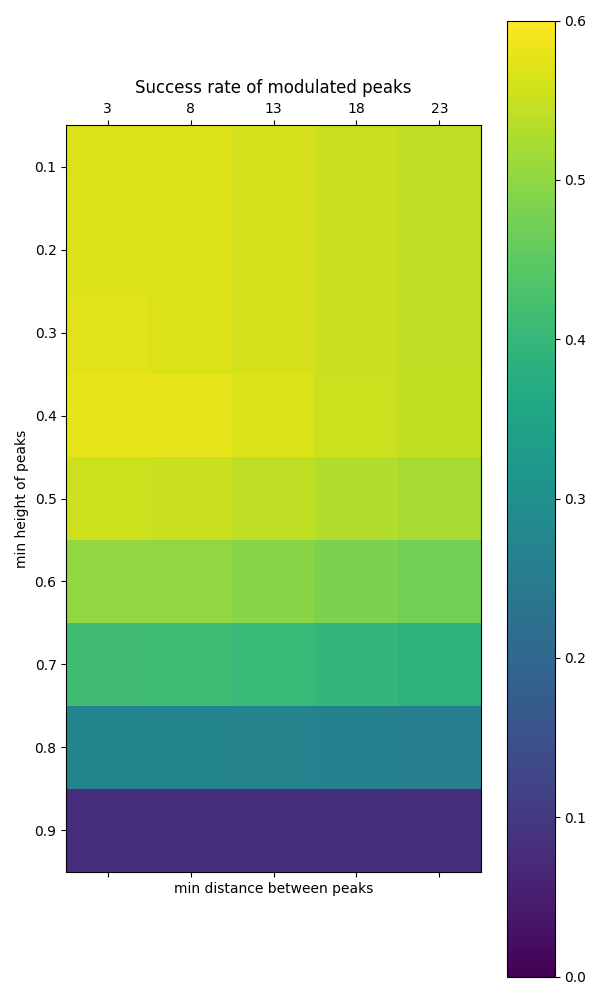

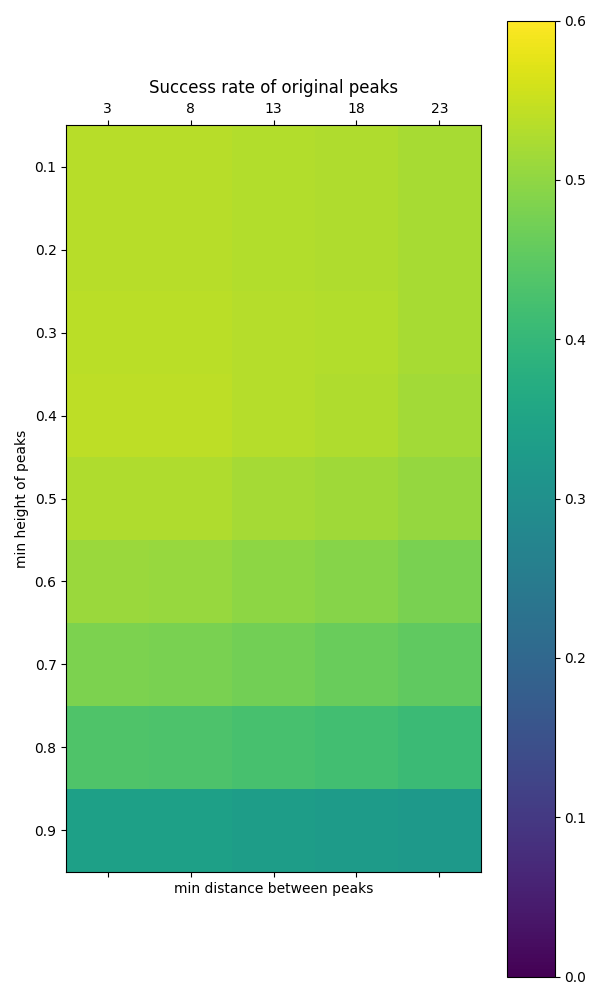

In [123]:
mod_peak_class_stats_per_h_d = get_peak_class_stats_per_h_d(overall_success, prefix="mod_peaks_")
orig_peak_class_stats_per_h_d = get_peak_class_stats_per_h_d(overall_success, prefix="orig_peaks_")


plot_heatmap(mod_peak_class_stats_per_h_d, title='Success rate of modulated peaks')
plot_heatmap(orig_peak_class_stats_per_h_d, title='Success rate of original peaks')

In [121]:
plt.close('all')

In [30]:
def construct_bboxes(x, cid, scores=None, dino_scores=None, score_func=np.mean, softmax_mul=0.0):
    aid = 1
    anns = []
    if scores is not None:
        for sc, d_sc, bb in zip(scores, dino_scores, x):
            # make sure that d_sc is greater than eps
            d_sc = np.maximum(d_sc, 1e-6)
            if softmax_mul:
                d_sc = softmax(d_sc * softmax_mul)
            for s, ds, b in zip(sc, d_sc, bb):
                bbox = [b['x1'], b['y1'], b['x2'] - b['x1'], b['y2'] - b['y1']]
                bbox = [float(a) for a in bbox]
                category_id = cid
                image_id = b['fno']
                ann_id = aid
                score = s
                anns.append({
                    'bbox': bbox,
                    'category_id': category_id,
                    'image_id': image_id,
                    'id': ann_id,
                    'score': score_func([score, ds]),
                    'area': bbox[2] * bbox[3],
                })
                aid += 1

    else:
        for bb in x:
            bbox = [bb['x'], bb['y'], bb['width'], bb['height']]
            bbox = [float(a) for a in bbox]
            category_id = cid
            image_id = bb['frame_number']
            ann_id = aid
            anns.append({
                'bbox': bbox,
                'category_id': category_id,
                'image_id': image_id,
                'id': ann_id,
                'iscrowd': False,
                'score': 1.0,
                'area': bbox[2] * bbox[3],
            })
            aid += 1
    return anns

def construct_imgs(x, num_valid_frames):
    fno = x[0]['frame_number']
    h, w = x[0]['original_height'], x[0]['original_width']
    imgs = []
    for i in range(num_valid_frames):
        imgs.append({
            'file_name': "n/a",
            'height': h,
            'width': w,
            'id': fno + i
        })
    return imgs

def get_ious(gt_anns, pred_anns, imgs, cid):
    from pycocotools.coco import COCO
    from pycocotools.cocoeval import COCOeval
    categories = [{'id': cid, 'name': f'target of val_{cid:10d}'}]
    with contextlib.redirect_stdout(io.StringIO()):
        gt = COCO()
        pred = COCO()
        gt.dataset = {'images': imgs, 'annotations': gt_anns, 'categories': categories}
        pred.dataset = {'images': imgs, 'annotations': pred_anns, 'categories': categories}
        gt.createIndex()
        pred.createIndex()
    # print(len(gt.getAnnIds()))
    # print(len(pred.getAnnIds()))
    # print(set([a['image_id'] for a in gt_anns]) - set([a['image_id'] for a in pred_anns]))
    # print(gt_anns[0:10])
    # print(pred_anns[0:10])
    gt_eval = COCOeval(gt, pred, 'bbox')
    gt_eval.params.imgIds = sorted(gt.getImgIds())
    gt_eval.params.catIds = sorted(gt.getCatIds())
    gt_eval.params.areaRng = [[0 ** 2, 1e10 ** 2]]
    gt_eval.params.maxDets = [1, 10, 128]
    gt_eval.params.areaRngLbl = ['all']
    # gt_eval.params.iouThrs = [0.5]
    gt_eval.params.useCats = 1
    # for k, v in gt_eval.params.__dict__.items():
    #     # check if v is an iterable
    #     if hasattr(v, '__iter__'):
    #         print(k, len(v), v[:10])
    #     else:
    #         print(k, v)
    with contextlib.redirect_stdout(io.StringIO()):
        gt_eval.evaluate()
        gt_eval.accumulate()
    # print(gt_eval.eval['precision'].shape)
    # print(gt_eval.eval['precision'].reshape(-1))
    # print(gt_eval.eval['recall'].reshape(-1))
    # print(gt_eval.eval['scores'].reshape(-1))
    return gt_eval.eval

# def get_ious_ignore(gt_anns, pred_anns, imgs, cid):
#     gt_iids = np.array([a['image_id'] for a in gt_anns]).astype(float)
#     pred_iids = np.array([a['image_id'] for a in pred_anns]).astype(float)
#     pred_scores = np.array([a['score'] for a in pred_anns]).astype(float)
#     gt_bboxs = np.array([a['bbox'] for a in gt_anns]).astype(float)
#     pred_bboxs = np.array([a['bbox'] for a in pred_anns]).astype(float)
#     ious = mask_util.iou(pred_bboxs, gt_bboxs, [False] * len(gt_bboxs))
#     valid_mask = (pred_iids[:, None] == gt_iids[None, :])
#     print(ious.shape, valid_mask.shape)
#     ious[~valid_mask] = -1.0
#     inds = np.argsort(-pred_scores, kind="mergesort")
#     ious = ious[inds]
#     max_iou_per_gt = ious.max(axis=0)
#     max_iou_per_dt = ious.max(axis=1)
#     argmax_iou_per_dt = ious.argmax(axis=1)
#     found = set()
#     keep_scores = []
#     for iou, ind in zip(max_iou_per_gt, argmax_iou_per_dt):
#         if iou > 0.5 and ind not in found:
#             found.add(ind)
#             keep_scores.append(pred_scores[ind])
#         elif iou >
        
    
#     return None, None



def run_episode(inputs):
    pred, gt, dino = inputs
    
    # print("gt keys:", gt.keys())
    # print("pred keys:", pred.keys())
    # print("gt response track keys:", gt['response_track'][0].keys())
    gt_fnos = [a['frame_number'] for a in gt['response_track']]
    pred_fnos = [a['frame_number'] for a in pred['groundtruth_response_tracks']]
    # print(len(pred['groundtruth_response_tracks']))
    assert gt_fnos == pred_fnos
    assert gt_fnos == list(range(min(gt_fnos), max(gt_fnos) + 1))
    assert (gt['dataset_uid'] == pred['dataset_uid'])
    # print(gt['query_frame'])
    num_frames = gt['query_frame']
    assert len(pred['predicted_bboxes']) == len(dino) == num_frames
    # assert 
    num_valid_frames = gt['query_frame'] - min(gt_fnos)
    # print(num_valid_frames)
    # print(len(pred['predicted_peaks']))
    valid_peaks = pred['predicted_peaks'][-num_valid_frames:]
    valid_bboxes = pred['predicted_bboxes'][-num_valid_frames:]
    valid_scores = pred['predicted_scores'][-num_valid_frames:]
    valid_gt = pred['groundtruth_response_tracks'][-num_valid_frames:]
    valid_dino = dino[-num_valid_frames:]
    assert len(valid_peaks) == len(valid_bboxes) == len(valid_scores) == len(valid_dino), (len(valid_peaks), len(valid_bboxes), len(valid_scores), len(valid_dino))
    # assert len(valid_peaks) == len(valid_bboxes) == len(valid_scores), (len(valid_peaks), len(valid_bboxes), len(valid_scores))
    assert valid_gt[0]['frame_number'] == min(gt_fnos), (valid_gt[0]['frame_number'], min(gt_fnos))
    
    cid = int(gt['dataset_uid'].split("_")[1]) + 1
    gt_anns = construct_bboxes(valid_gt, cid, scores=None)
    pred_anns = construct_bboxes(valid_bboxes, cid, scores=valid_scores, dino_scores=valid_dino, score_func=lambda x: np.sqrt(x[0] * x[1]), softmax_mul=0.0)
    imgs = construct_imgs(valid_gt, num_valid_frames)
    len_gt_anns = len(gt_anns)
    len_pred_anns = len(pred_anns)
    len_imgs = len(imgs)
    min_gt_iid = min([a['image_id'] for a in gt_anns])
    max_gt_iid = max([a['image_id'] for a in gt_anns])
    min_pred_iid = min([a['image_id'] for a in pred_anns])
    max_pred_iid = max([a['image_id'] for a in pred_anns])
    min_img_iid = min([a['id'] for a in imgs])
    max_img_iid = max([a['id'] for a in imgs])
    assert min_gt_iid == min_pred_iid == min_img_iid
    assert max_img_iid == max_pred_iid
    assert len_gt_anns == max_gt_iid - min_gt_iid + 1, (len_gt_anns, max_gt_iid - min_gt_iid + 1)
    # print("length of gt anns:", len(gt_anns))
    # print("length of pred anns:", len(pred_anns))
    # print("length of imgs:", len(imgs))
    # print("min gt_anns fno:", min([a['image_id'] for a in gt_anns]))
    # print("max gt_anns fno:", max([a['image_id'] for a in gt_anns]))
    # print("min pred_anns fno:", min([a['image_id'] for a in pred_anns]))
    # print("max pred_anns fno:", max([a['image_id'] for a in pred_anns]))
    # print("min imgs fno:", min([a['id'] for a in imgs]))
    # print("max imgs fno:", max([a['id'] for a in imgs]))
    # assert min([a['image_id'] for a in gt_anns]) == min([a['image_id'] for a in pred_anns]) == min([a['id'] for a in imgs])
    # assert max([a['image_id'] for a in pred_anns]) == max([a['id'] for a in imgs])
    # assert len(gt_anns) == len(imgs)

    out_no_ignore = get_ious(gt_anns, pred_anns, imgs, cid)
    del out_no_ignore['params']
    out_no_ignore['dataset_uid'] = gt['dataset_uid']

    return out_no_ignore
    # for k, v in out_no_ignore.items():
    #     if k in ['precision', 'recall', 'scores']:
    #         print(k, v.shape)
    # out_ignore, neg_frames = get_ious_ignore(gt_anns, pred_anns, imgs, cid)

In [31]:
def run_outer_episode(i, duid2gt=None):
    pred_path = PATH_TO_PREDS.format(i)
    save_path = pred_path.replace(".json.gz", "_pr_sc_dino_gmean.pkl")
    if os.path.exists(save_path):
        return
    dino_path = PATH_TO_DINO.format(i)
    pred = preprocess_data(pred_path)
    dino = preprocess_dino(dino_path)
    duid2pred = {p['dataset_uid']: p for p in pred}
    # duid2gt = {g['dataset_uid']: g for g in gt}
    valid_duids = set([ann['dataset_uid'] for ann in duid2gt.values() if ann['clip_uid'] is not None])
    duid2pred = {k: v for k, v in duid2pred.items() if k in valid_duids}
    duid2gt = {k: v for k, v in duid2gt.items() if k in duid2pred.keys()}
    duid2dino = {duid: dino[duid] for duid in duid2pred}
    assert len(duid2pred) == len(duid2gt) == len(duid2dino)
    inputs = [(duid2pred[k], duid2gt[k], duid2dino[k]) for k in sorted(duid2pred.keys())]
    outputs = [run_episode(inp) for inp in inputs]
    # save_path = pred_path.replace(".json.gz", "_pr_dino_only.pkl")
    with open(save_path, "wb") as f:
        pickle.dump(outputs, f)
    


In [32]:
with open("/scratch/shared/beegfs/prannay/ego4d_data/ckpt/results/traces_v2_all/available_all.txt", "r") as f:
    available = f.read().splitlines()
    available = sorted([int(a.split("_")[3]) for a in available])
print(available)
print(len(available))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
200


In [130]:
# duid = list(duid2pred.keys())[0]

In [131]:
# outputs_test = []
# for duid in tqdm(sorted(duid2pred.keys()), total=len(duid2pred.keys())):
#     output = run_episode((duid2pred[duid], duid2gt[duid], duid2dino[duid]))
#     outputs_test.append(output)

In [132]:
# inputs = [(duid2pred[duid], duid2gt[duid]) for duid in sorted(duid2pred.keys())]
# with Pool(32) as p:
#     outputs = list(tqdm(p.imap_unordered(run_episode, inputs), total=len(inputs)))
# # for duid in tqdm(sorted(duid2pred.keys())):
# #     outputs.append(run_episode(duid2pred[duid], duid2gt[duid]))

In [33]:
from functools import partial
with open(PATH_TO_ANNS, "r") as f:
    gt = json.load(f)
duid2gt = {g['dataset_uid']: g for g in gt if g['clip_uid'] is not None}
# try without Pool
# outputs = []
# for ind in tqdm(available, total=len(available)):
#     run_outer_episode(ind, duid2gt=duid2gt)
# try with Pool
with Pool(16) as p:
    _ = list(tqdm(p.imap_unordered(partial(run_outer_episode, duid2gt=duid2gt), available), total=len(available)))
    # _ = list(tqdm(p.imap_unordered(partial(run_outer_episode, duid2gt=duid2gt), available), total=len(available)))
# for i in tqdm(range(0, 1), total=1):
    # run_outer_episode(i, duid2gt)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
# import pickle
# PATH_TO_SAVE = "/scratch/shared/beegfs/prannay/ego4d_data/ckpt/results/traces_v2_all/vq_pr_stats_val_all.pkl"
# with open(PATH_TO_SAVE, "wb") as f:
#     pickle.dump(outputs, f)